## PROBLEM 5: DBSCAN on toy-neighborhood data

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances


In [90]:
data = pd.read_csv('dataset/dbscan.csv')
data

,cluster,pt,x,y,num_neighbors,neighbors
0,NaN,0,51.418089,13.593610,2,"0,27"
1,NaN,1,39.132318,-4.419204,3,"1,40,75"
2,NaN,2,47.807515,-25.822561,1,2
3,NaN,3,27.699703,53.434193,1,3
4,NaN,4,39.860995,5.676871,3,"4,56,75"
...,...,...,...,...,...,...
75,NaN,75,39.659047,0.230178,3,"1,4,75"
76,NaN,76,26.366491,8.798826,3,"21,49,76"
77,NaN,77,-36.184060,44.292045,2,"55,77"
78,NaN,78,44.012085,37.729478,3,"9,33,78"


In [2]:
def dbscan(data, minPts):
    '''
    Implement DBScan with Euclidean distance
    :param data: dataframe containing the data
    :param minPts: density threshold
    :return: dataframe with assigned clusters
    '''
    cluster = 0
    visited = set() # Keep track of visited points as row['cluster'] might not update immediately
    for index, row in data.iterrows():
        if index not in visited and row['num_neighbors'] >= minPts:
            cluster += 1
            queue = [index]
            while queue:
                #print("Queue: ", queue)
                current_index = queue.pop(0)
                #print("current index: ", current_index)
                if pd.isna(data.at[current_index, 'cluster']):
                    data.at[current_index, 'cluster'] = cluster

                neighbors = data.at[current_index, 'neighbors'].strip().split(',')
                #print(f"neighbors of index {current_index}: {neighbors}")
                for neighbor in neighbors:
                    neighbor = int(neighbor)
                    if pd.isna(data.at[neighbor, 'cluster']):
                        if data.at[neighbor, 'num_neighbors'] >= minPts:
                            #print("adding to queue: ", neighbor)
                            queue.append(neighbor)
                        data.at[neighbor, 'cluster'] = cluster
                        #print(f"Set cluster of {neighbor}: {cluster}")
                        visited.add(neighbor)
                visited.add(current_index)
    data['cluster'] = data['cluster'].fillna(-1)
    return data

In [110]:
input_data = data.copy()
clustered_data = dbscan(input_data, 3)

Queue:  [1]
current index:  1
neighbors of index 1: ['1', '40', '75']
adding to queue:  40
Set cluster of 40: 1
adding to queue:  75
Set cluster of 75: 1
Queue:  [40, 75]
current index:  40
neighbors of index 40: ['1', '28', '40']
adding to queue:  28
Set cluster of 28: 1
Queue:  [75, 28]
current index:  75
neighbors of index 75: ['1', '4', '75']
adding to queue:  4
Set cluster of 4: 1
Queue:  [28, 4]
current index:  28
neighbors of index 28: ['12', '28', '40']
Set cluster of 12: 1
Queue:  [4]
current index:  4
neighbors of index 4: ['4', '56', '75']
adding to queue:  56
Set cluster of 56: 1
Queue:  [56]
current index:  56
neighbors of index 56: ['4', '56', '66']
Set cluster of 66: 1
Queue:  [5]
current index:  5
neighbors of index 5: ['5', '70', '74']
adding to queue:  70
Set cluster of 70: 2
adding to queue:  74
Set cluster of 74: 2
Queue:  [70, 74]
current index:  70
neighbors of index 70: ['5', '32', '69', '70', '72']
adding to queue:  32
Set cluster of 32: 2
adding to queue:  69
S

In [108]:
clustered_data['cluster'].value_counts()

cluster
 2.0    43
-1.0    26
 1.0     8
 3.0     3
Name: count, dtype: int64

In [3]:
import matplotlib.pyplot as plt

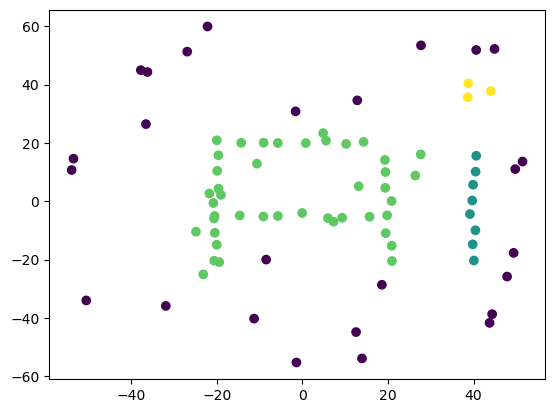

In [94]:
plt.scatter(clustered_data['x'], clustered_data['y'], c=clustered_data['cluster'])

In [4]:
from sklearn.metrics import silhouette_score

In [106]:
mask = clustered_data['cluster'] != -1
silhouette_score(clustered_data[mask][['x','y']], clustered_data[mask]['cluster'])

0.3597027667093029

## PROBLEM 6: DBSCAN on toy raw data

In [5]:
from sklearn.datasets import make_moons, make_blobs, make_circles

In [9]:
def find_neighbors_by_eps(data, eps):
    neighbors_lst = []
    num_neighbor_lst = []
    for row in pairwise_distances(data):
        neighbors = []
        for i, d in enumerate(row):
            if d <= eps:
                neighbors.append(i)
        num_neighbor = len(neighbors)
        num_neighbor_lst.append(num_neighbor)

        if neighbors:    
            neighbors = ",".join(map(str,neighbors))
        neighbors_lst.append(neighbors)
    new_data = data.copy()
    new_data.loc[:, 'num_neighbors'] = num_neighbor_lst
    new_data.loc[:, 'neighbors'] = neighbors_lst    
    new_data.loc[:, 'cluster'] = np.nan 
    return new_data

def dataset2df(X):
    return  pd.DataFrame(X, columns=['x','y'])


In [6]:
X, y = make_moons()
moon_df = dataset2df(X)

In [257]:

moons = find_neighbors_by_eps(moon_df, 0.2)
clustered_moons = dbscan(moons, 3)
clustered_moons['cluster'].value_counts()

cluster
1.0    50
2.0    50
Name: count, dtype: int64

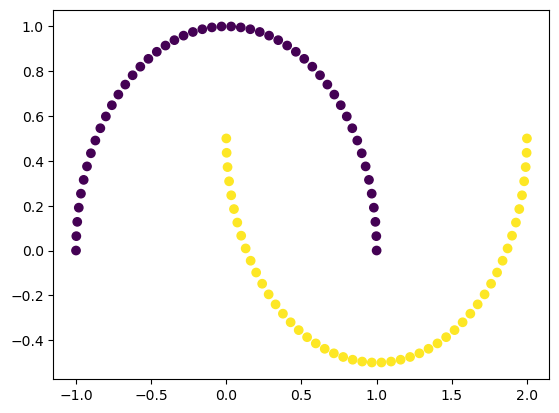

In [171]:
plt.scatter(clustered_moons['x'], clustered_moons['y'], c=clustered_moons['cluster'])

In [259]:
silhouette_score(clustered_moons[['x','y']],clustered_moons['cluster'])

0.316148238855915

In [5]:
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(data, minpts):
    nn = NearestNeighbors(n_neighbors=minpts)
    nn.fit(data)
    distances, _ = nn.kneighbors(data)
    distances = np.sort(distances[:, minpts-1])  # Get the k-th nearest neighbor distance
    
    plt.plot(distances)
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{minpts}-th Nearest Neighbor Distance")
    plt.title("k-Distance Graph (Elbow Method for Epsilon)")
    plt.show()


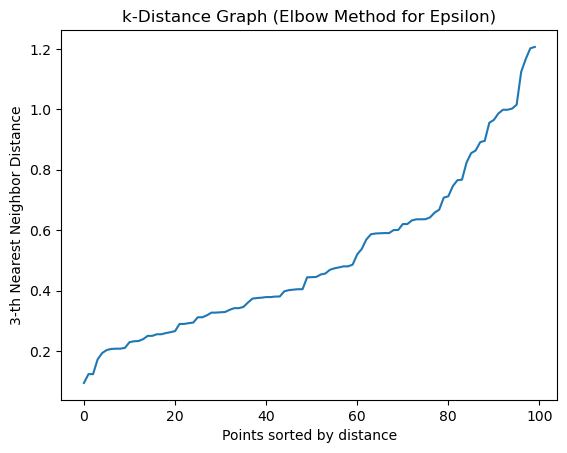

In [260]:
X, y = make_blobs()
plot_k_distance(X, 3)

In [261]:
df = dataset2df(X)
blob = find_neighbors_by_eps(df, 0.6)
clustered_blob = dbscan(blob, 3)
clustered_blob['cluster'].value_counts()

cluster
 3.0    29
 1.0    25
-1.0    22
 6.0     8
 2.0     6
 4.0     4
 5.0     3
 7.0     3
Name: count, dtype: int64

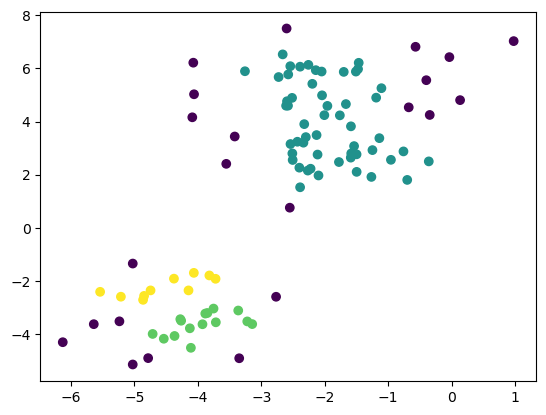

In [181]:
plt.scatter(clustered_blob['x'], clustered_blob['y'], c=clustered_blob['cluster'])

In [262]:
silhouette_score(clustered_blob[['x','y']], clustered_blob['cluster'])

0.3686680230537728

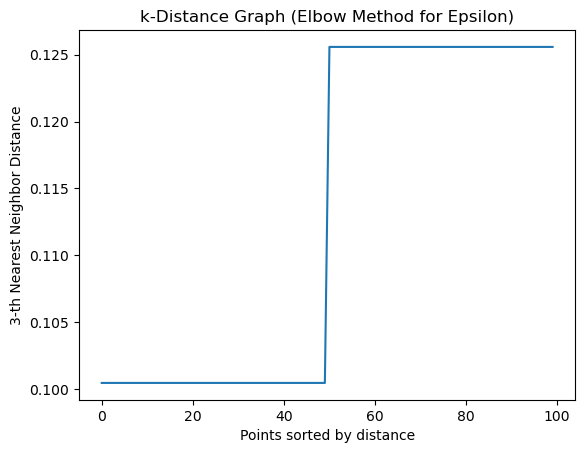

In [267]:
X, y = make_circles()
plot_k_distance(X, 3)

In [268]:
df = dataset2df(X)
circles = find_neighbors_by_eps(df, 0.15)
clustered_circles = dbscan(circles, 3)
clustered_circles['cluster'].value_counts()

cluster
1.0    50
2.0    50
Name: count, dtype: int64

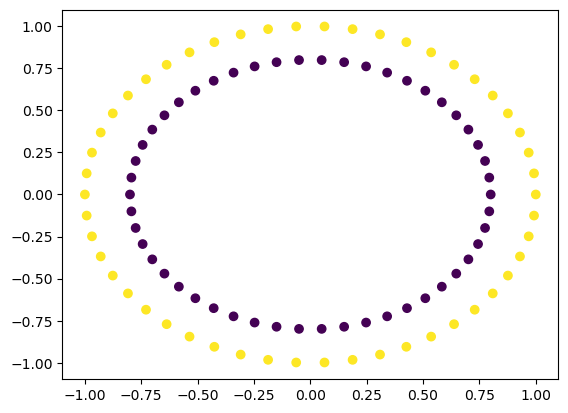

In [269]:
plt.scatter(clustered_circles['x'], clustered_circles['y'], c=clustered_circles['cluster'])

In [270]:
silhouette_score(clustered_circles[['x','y']], clustered_circles['cluster'])

0.004707770080756236

In [271]:
clustered_circles

,x,y,num_neighbors,neighbors,cluster
0,0.149905,-0.785830,3,"0,33,89",1.0
1,0.929776,0.368125,3,"1,14,99",2.0
2,0.309017,0.951057,3,"2,44,71",2.0
3,-0.876307,0.481754,3,"3,36,46",2.0
4,0.309017,-0.951057,3,"4,24,51",2.0
...,...,...,...,...,...
95,-0.637424,-0.770513,3,"81,92,95",2.0
96,0.428661,0.675462,3,"9,20,96",1.0
97,0.992115,-0.125333,3,"8,69,97",2.0
98,0.701045,-0.385403,3,"38,43,98",1.0


## PROBLEM 7: DBSCAN on real data

In [6]:
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

In [190]:
household_df = pd.read_csv('dataset/household_power_consumption.txt', delimiter=';')
household_df

C:\Users\fred9\AppData\Local\Temp\ipykernel_16268\3648692726.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  household_df = pd.read_csv('dataset/household_power_consumption.txt', delimiter=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [4]:
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

numberic_mask = household_df.loc[:, 'Global_active_power':].map(is_numeric)
numberic_df = household_df.loc[:, 'Global_active_power':][numberic_mask].dropna().astype(float)
numberic_df

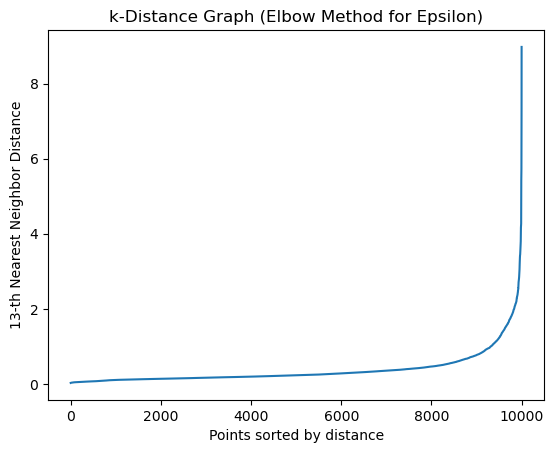

In [331]:
scaler = StandardScaler()
standardized_data = pd.DataFrame(scaler.fit_transform(sample_df.loc[:, 'Global_active_power':])) #
plot_k_distance(standardized_data, 13)

In [333]:
household_neighbors = find_neighbors_by_eps(standardized_data, 1.5)
clustered_household_neighbors = dbscan(household_neighbors, 13)
clustered_household_neighbors['cluster'].value_counts()

cluster
 1.0    9451
 2.0     207
-1.0     177
 4.0      89
 3.0      76
Name: count, dtype: int64

In [336]:
mask = clustered_household_neighbors["cluster"] != -1
silhouette_score(clustered_household_neighbors.loc[mask,:6], clustered_household_neighbors.loc[mask,'cluster']) #6 is the last feature
#clustered_household_neighbors.columns

0.56805711564402

In [43]:
# fashion dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
fashion_df = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
standardized_X_test = pd.DataFrame(normalize(fashion_df, norm="l2", axis=1))

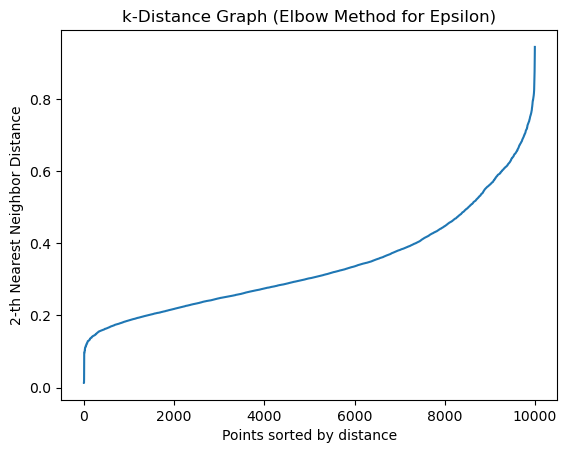

In [343]:
plot_k_distance(standardized_X_test, 2)

In [45]:
fashion_neighbors = find_neighbors_by_eps(standardized_X_test, 0.75)
clustered_fashion_neighbors = dbscan(fashion_neighbors, 2)
clustered_fashion_neighbors['cluster'].value_counts()
mask = clustered_fashion_neighbors["cluster"] != -1
silhouette_score(clustered_fashion_neighbors.loc[mask,:783], clustered_fashion_neighbors.loc[mask,'cluster'])

0.20343084954122762

In [7]:
## 20NG
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=17)

# Apply TF normalization
vectorizer = TfidfVectorizer()
test_documents_tfidf = vectorizer.fit_transform(test_data.data)
document_array = pd.DataFrame(test_documents_tfidf.toarray())


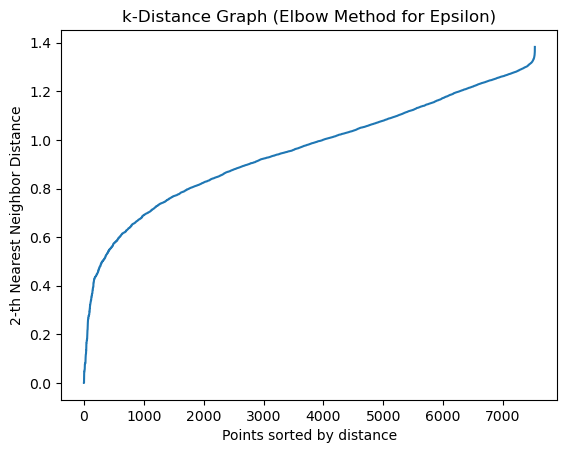

In [13]:
plot_k_distance(document_array, 2)

In [ ]:
ng20_neighbors = find_neighbors_by_eps(document_array, 1.3)
clustered_ng20_neighbors = dbscan(ng20_neighbors, 2)
mask = clustered_ng20_neighbors["cluster"] != -1
silhouette_score(clustered_ng20_neighbors.loc[mask,:93563], clustered_ng20_neighbors.loc[mask,'cluster'])

0.002559849064430309

In [14]:
 ng20_neighbors = find_neighbors_by_eps(document_array, 1.32)
clustered_ng20_neighbors = dbscan(ng20_neighbors, 2)
mask = clustered_ng20_neighbors["cluster"] != -1
silhouette_score(clustered_ng20_neighbors.loc[mask,:93563], clustered_ng20_neighbors.loc[mask,'cluster'])

0.010091380500637152

In [24]:
ng20_neighbors = find_neighbors_by_eps(document_array, 1.5)
clustered_ng20_neighbors = dbscan(ng20_neighbors, 2)
clustered_ng20_neighbors['cluster'].value_counts()

cluster
1.0    7532
Name: count, dtype: int64

DBScan works better no the household dataset as there are fewer features. On the other hand, fashion mnist and 20NG have a lot of features, which makes it difficult to find clusters.

## PROBLEM 8: Hierarchical Clustering

In [12]:
X,y = make_moons(500, noise=0.05, random_state=17)

In [13]:
from queue import PriorityQueue

def hierarchical_clustering(X):
    D = pairwise_distances(X)
    n = len(X)
    pq = PriorityQueue()
    clusters = {i: [i] for i in range(n)}
    active_clusters = set(clusters.keys())
    #print(len(active_clusters))
    for i in range(n):
        for j  in range(i + 1,n):
            pq.put((D[i,j], i, j))
    #print(len(pq.queue))
    linkage_matrix = []
    next_cluster_id = n
    while len(active_clusters) > 1:
        #extract min distance
        distance, ci, cj = pq.get()
        if ci not in active_clusters or cj not in active_clusters:
            continue
            
        #merge clusters ci and cj
        new_cluster_points = clusters[ci] + clusters[cj]
        linkage_matrix.append((ci,cj,distance))
        clusters[next_cluster_id] = new_cluster_points
        active_clusters.remove(ci)
        active_clusters.remove(cj)
        active_clusters.add(next_cluster_id)
        
        # update distances: for each remaining cluster, compute the distance to the new cluster
        for other in active_clusters:
            if other == next_cluster_id:
                continue
            # using the minimum distance between a point in new cluster and a point in other cluster
            min_distance = float('inf')
            for i_idx in new_cluster_points:
                for j_idx in clusters[other]:
                    if D[i_idx,j_idx] < min_distance:
                        min_distance = D[i_idx,j_idx]
            pq.put((min_distance, next_cluster_id, other))            
            
        next_cluster_id +=1
        
    return np.array(linkage_matrix), clusters


def split_clusters(linkage_matrix, clusters,k):
    n = len(linkage_matrix) + 1
    parent = list(range(n))
    
    def find(x):
        if parent[x] != x:
            parent[x] = find(parent[x])
        return parent[x]
    
    def union(x,y):
        rx, ry = find(x), find(y)
        if rx != ry:
            parent[rx] = ry
            
    num_merges_to_process = n - k
    for merge in linkage_matrix[:num_merges_to_process]:
        ci, cj, dist = merge
        points = clusters[ci] + clusters[cj]
        rep = points[0]
        for pt in points:
            union(pt, rep)
            
    cluster_dict = {}
    for i in range(n):
        root = find(i)
        cluster_dict.setdefault(root, []).append(i)
        
    return list(cluster_dict.values())
    

    

In [14]:
linkage_matrix, clusters = hierarchical_clustering(X)

In [38]:
def evaluate_clusters(X, linkage_matrix, clusters, k):
    result = split_clusters(linkage_matrix, clusters,k)
    d = {}
    for i, v in enumerate(result):
        for j in v:
            d[j] = i
    clusters = [d[key] for key in sorted(d.keys())] 
    print(clusters)
    #plt.scatter(X[:,0],X[:,1],c=clusters)
    #plt.show()
    print(f"score for k={k}: ", silhouette_score(X,clusters))
      

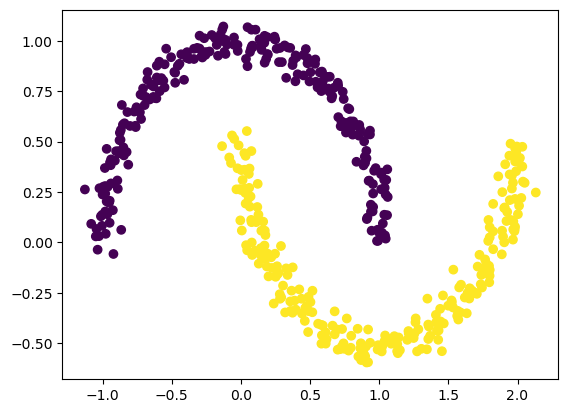

score for k=2:  0.3315208742577139


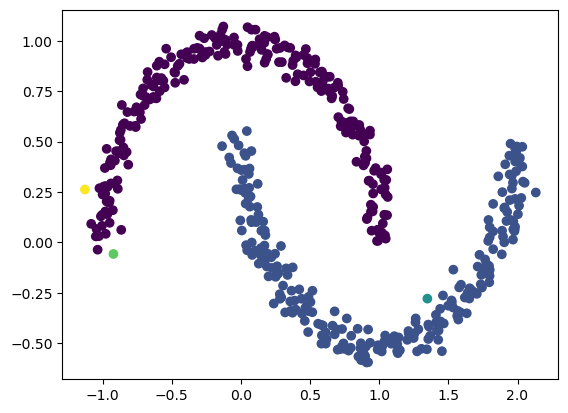

score for k=5:  -0.1988198200306116


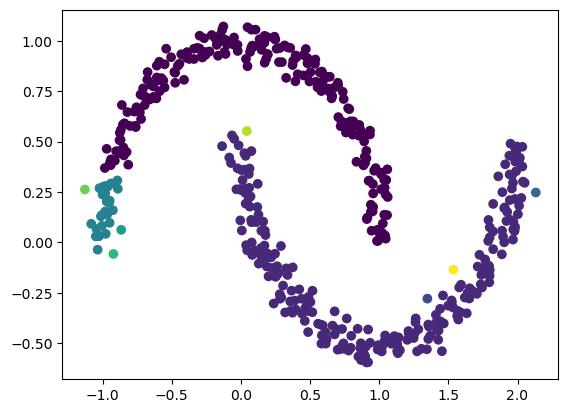

score for k=10:  -0.3991650091087204


In [37]:
for k in [2,5,10]:
    evaluate_clusters(X, linkage_matrix, clusters, k)